# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads 2 npz files for your use: labels.npz and images.npz. For those not using colab you can download manually here:

https://drive.google.com/open?id=1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu

https://drive.google.com/open?id=1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0

https://drive.google.com/file/d/1tkpFDxbpP61OEic7EP4LOhUKclYJLlwr/view?usp=sharing

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/drive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW2')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
    '1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
    '1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz',
    '1mm5mq7ngx5D2QHFedjucyUC3z0VDeSRj': 'test_y_labels.npz'       }

# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

Here you will implement a pytorch data processor that loads tha images and computes the ground truth labels as described in the PDF.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def loadData(image_path, labels_path):
  ## use 0.8*no_images as the training data and the remaining as test data.
  image = np.load("/content/images.npz",allow_pickle=True)['arr_0']
  label = np.load("/content/labels.npz",allow_pickle=True,encoding = "latin1")['arr_0']
  train_images,test_images,train_raw_lables,test_raw_labels = train_test_split(image, label, test_size=0.20,shuffle=True)
  return train_images, test_images, train_raw_lables, test_raw_labels

def create_y_label(image, raw_label):
  ## this function should compute the 8X8X8 label from the raw labels for the corresponding image.
  y_label = np.zeros((8,8,8))
  for label in raw_label:
    x1,y1,x2,y2 = label[1:]
    center_x = (x1+ x2) / 2 
    center_y = (y1 + y2) / 2
    x_index = int(center_x/16)
    y_index = int(center_y/16)
    offset_x = (center_x %16) / 16
    offset_y = (center_y %16) / 16

    #Finding the width and height 
    w = (x2 - x1)/128
    h = (y2 - y1)/128
    class_label = label[0]
    label_one_hot =np.zeros(3)
    label_one_hot[int(label[0])] = 1
    

    y_label[0:5,x_index,y_index] = [1,offset_x,offset_y,w,h]
    y_label[5:,x_index,y_index] = label_one_hot

  return y_label

In [ ]:
train_images, test_images, train_raw_lables, test_raw_labels = loadData('/content/images.npz', '/content/labels.npz')

TEST your processed y_labels.

The following test checks your create_y_labels function using the test_y_label.npz file.

In [ ]:

data = np.load("test_y_labels.npz",allow_pickle=True)
## the test data contains 5 - (image, raw_label, processed_label) that is 5 test cases 

img = data['image']   ## shape (5,3,128,18)
raw_label = data['raw_label']
true_y_label = data['y_label']  ## shape (5,8,8,8)

## fill in your code to compute the your processed y_label
y_label = np.zeros((5,8,8,8))


for i, label in enumerate(raw_label):
  y_label[i] = create_y_label(img[i], label)



# test you processed labels
for i in range(len(img)):
  # print("Y label",y_label[i])
  # print("Y  true label",true_y_label[i])
  comparison = y_label[i] == true_y_label[i]
  equal_arrays = comparison.all()
  print('Completed TEST CASE {}: {}'.format(i+1,equal_arrays))


Completed TEST CASE 1: True
Completed TEST CASE 2: True
Completed TEST CASE 3: True
Completed TEST CASE 4: True
Completed TEST CASE 5: True


Test your DATASET

Test your data processing by plotting the images and the processed labels. Compare against the raw labels. 

Set up the data set for training and testing.

In [ ]:
import torch 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [ ]:
class YOLODataset(torch.utils.data.Dataset):
  
  def __init__(self, image_file, label_file, transform = None):
    self.images = image_file
    self.labels = label_file
    self.transform = transform
    
  def __len__(self):
    return len(self.labels)
    
  def __getitem__(self, index):
    sample_image = self.images[index]
    sample_label = self.labels[index]
    
    if self.transform:
      sample_image = self.transform(sample_image)

    sample_image = sample_image.transpose((2,0,1))
    sample_image = torch.tensor(sample_image).type(torch.FloatTensor)
    #new_label = torch.tensor(create_y_label(sample_image,sample_label))
    #print(sample_label)
    #sample_label = torch.tensor(convertLabel(sample_label))
          
    return (sample_image, sample_label)

# 7.2.1

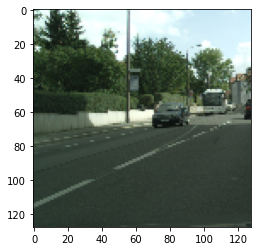

In [ ]:
train_dataset = YOLODataset(test_images, test_raw_labels)
image,new_label = train_dataset.__getitem__(22)
images = image.type(torch.IntTensor).numpy()
images = np.transpose(images,(1,2,0))
fig,ax = plt.subplots(1)
ax.imshow(images)

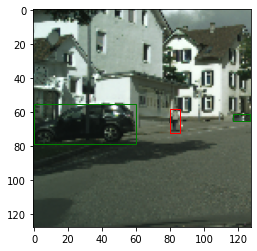

In [ ]:
train_dataset = YOLODataset(test_images, test_raw_labels)
image,new_label = train_dataset.__getitem__(87)
images = image.type(torch.IntTensor).numpy()
images = np.transpose(images,(1,2,0))
fig,ax = plt.subplots(1)
ax.imshow(images)
for i in range(len(new_label)):
  #For detecting Pedestrian
  if new_label[i][0] == 0:
    rect1 = patches.Rectangle((new_label[i][1],new_label[i][2]),(new_label[i][3]-new_label[i][1]),(new_label[i][4]-new_label[i][2]),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect1)
    #For detecting Traffic Light
  if new_label[i][0] == 1:
    rect2 = patches.Rectangle((new_label[i][1],new_label[i][2]),(new_label[i][3]-new_label[i][1]),(new_label[i][4]-new_label[i][2]),linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect2)
    #For detecting Car
  if new_label[i][0] == 2:
    rect3 = patches.Rectangle((new_label[i][1],new_label[i][2]),(new_label[i][3]-new_label[i][1]),(new_label[i][4]-new_label[i][2]),linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(rect3)
        
plt.show()

# 7.2.2

In [ ]:
train_dataset = YOLODataset(train_images, train_raw_lables)
image,label = train_dataset.__getitem__(87)
op = create_y_label(image,label)
for i in range(8):
  op[i] = op[i].T

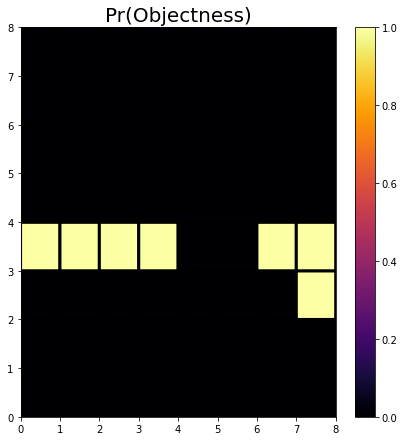

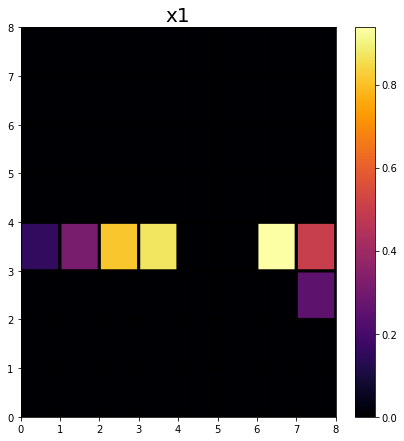

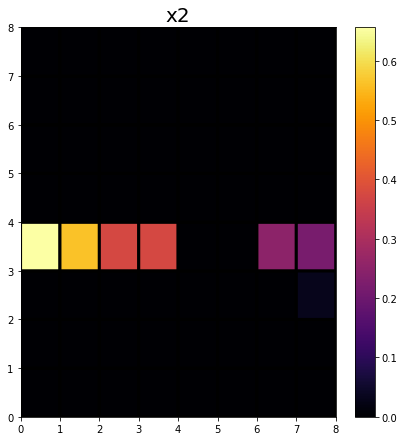

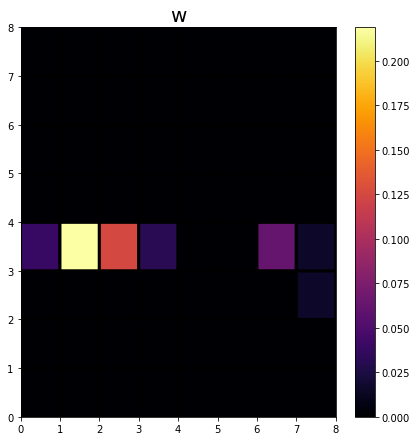

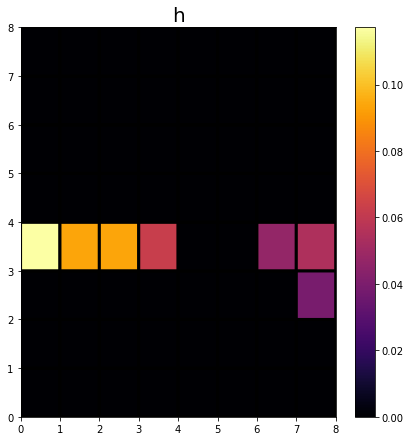

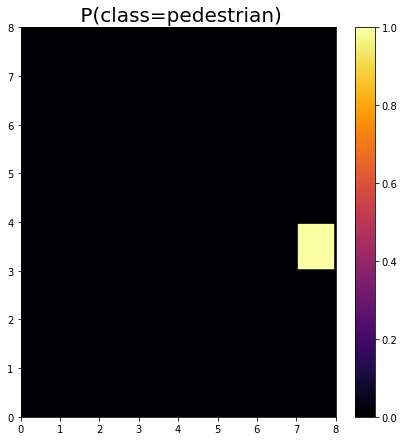

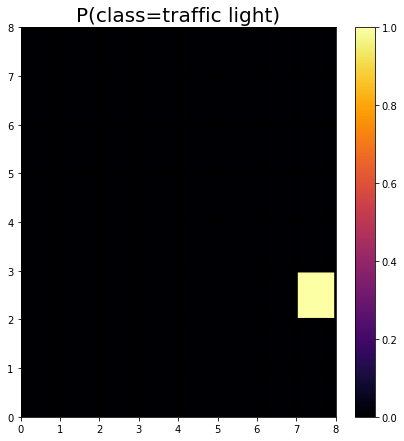

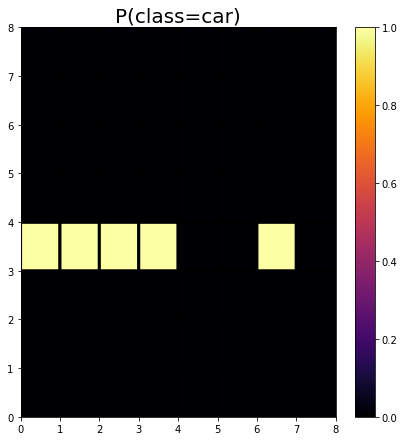

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import colors
Title = ["Pr(Objectness)", "x1","x2","w","h"," P(class=pedestrian)", "P(class=traffic light)", "P(class=car)"]
for i in range(8):
  fig = plt.figure(figsize=(6,6))
  plt.pcolor(op[i],cmap='inferno',edgecolors='k', linewidths=3)
  plt.tight_layout()
  plt.title(Title[i], fontsize=20)
  plt.colorbar()
  plt.show()

# 7.2.3

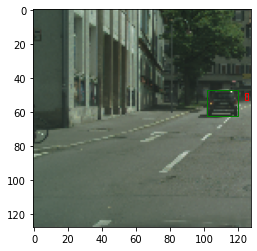

In [ ]:
train_dataset = YOLODataset(train_images, train_raw_lables)
image,label = train_dataset.__getitem__(87)
label1 = create_y_label(image,label)
image = image.type(torch.IntTensor).numpy()
image = np.transpose(image,(1,2,0))
fig,ax = plt.subplots(1)
ax.imshow(image)
for i in range(8):
  label1[i] = label1[i].T

for i in range(8):
  for j in range(8):
    if label1[0][i][j]>0.5:
      if label1[5][i][j]>0.5:
        width = label1[3][i][j]*128
        height = label1[4][i][j]*128
        xcoord = label1[1][i][j]*16 + j*16 -width/2
        ycoord = label1[2][i][j]*16 + i*16 - height/2
        rect1 = patches.Rectangle((xcoord,ycoord),width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
      if label1[6][i][j]>0.5:
        width = label1[3][i][j]*128
        height = label1[4][i][j]*128
        xcoord = label1[1][i][j]*16 + j*16 - width/2
        ycoord = label1[2][i][j]*16 + i*16 - height/2
        rect2 = patches.Rectangle((xcoord,ycoord),width,height,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect2)
      if label1[7][i][j]>0.5:
        width = label1[3][i][j]*128
        height = label1[4][i][j]*128
        xcoord = label1[1][i][j]*16 + j*16 - width/2
        ycoord = label1[2][i][j]*16 + i*16 - height/2
        rect3 = patches.Rectangle((xcoord,ycoord),width,height,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect3)
        
plt.show()

# Model Definition

In [ ]:
class YOLO(torch.nn.Module):
  def __init__(self):
    super(YOLO, self).__init__()
    self.convolution1 = nn.Conv2d(3, 32,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm1 = nn.BatchNorm2d(32)
    
    self.convolution2 = nn.Conv2d(32, 64,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm2 = nn.BatchNorm2d(64)
    
    self.convolution3 = nn.Conv2d(64, 128,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm3 = nn.BatchNorm2d(128)
    
    self.convolution4 = nn.Conv2d(128, 256,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm4 = nn.BatchNorm2d(256)
    
    self.convolution5 = nn.Conv2d(256, 512,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm5 = nn.BatchNorm2d(512)
    
    self.convolution6 = nn.Conv2d(512, 1024,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm6 = nn.BatchNorm2d(1024)
    
    self.convolution7 = nn.ConvTranspose2d(1024,256,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm7 = nn.BatchNorm2d(256)
    
    self.convolution8 = nn.ConvTranspose2d(256, 64,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm8 = nn.BatchNorm2d(64)
    
    self.convolution9 = nn.Conv2d(64, 8,
                              kernel_size=3,
                              stride=1, padding = (1,1))
      
  def forward(self, x):
    
    x = F.relu(self.batchnorm1(self.convolution1(x.float())))
    x = F.relu(self.batchnorm2(self.convolution2(x)))
    x = F.relu(self.batchnorm3(self.convolution3(x)))
    x = F.relu(self.batchnorm4(self.convolution4(x)))
    x = F.relu(self.batchnorm5(self.convolution5(x)))
    x = F.relu(self.batchnorm6(self.convolution6(x)))
    x = F.relu(self.batchnorm7(self.convolution7(x)))
    x = F.relu(self.batchnorm8(self.convolution8(x)))
    x = torch.sigmoid(self.convolution9(x))
      
    return x



# Training you network

Start by defining the 
1. IOU
2. appropropriate loss function.
3. NMS - non-max suppression function
4. Average precision function

Please define additional functions as needed.

In [ ]:
def decode_box(code,objects):
  box = torch.zeros(4)
  x,y,w,h = code[1:5]
  re_w=w*128
  re_h=h*128
  re_x=x*16
  re_y=y*16
  grid_x = objects[1]
  grid_y = objects[2]
  box[0] = grid_x *16 + re_x -re_w/2
  box[1] = grid_y *16 + re_y -re_h/2
  box[2] = grid_x *16 + re_x  + re_w/2
  box[3] = grid_y *16 + re_y  + re_h/2
  return box


def IOU(bbox_1, bbox_2):
   ## please fill in additional arguements
   x_1up = bbox_1[0]
   y_1up = bbox_1[1]
   x_11 = bbox_1[2]
   y_11 = bbox_1[3]
   
   x_2up = bbox_2[0]
   y_2up = bbox_2[1]
   x_21 = bbox_2[2]
   y_21 = bbox_2[3]

   x_up = max(x_1up,x_2up)
   y_up = max(y_1up,y_2up)
   x_1 = min(x_11,x_21)
   y_1 = min(y_11,y_21)
   
   inter_area = max((x_1 - x_up + 1),0) * max((y_1 - y_up + 1),0)
   area_box1 = (x_11 - x_1up + 1) * (y_11 - y_1up + 1)
   area_box2 = (x_21 - x_2up + 1) * (y_21 - y_2up + 1)
   union_area = area_box1 + area_box2 - inter_area 
   iou = inter_area / union_area
   return iou

def calc_confidence_score(prediction, grnd_truth,objects):
  ## please fill in additional arguements
  num_objects = prediction.shape[0]
  C_true = torch.zeros(num_objects)
  #predicted_bbox = prediction.shape[0]
  #grnd_truth_bbox = torch.zeros(num_objects)
  for i in range(num_objects):
    predicted_bbox = decode_box(prediction[i,:],objects[i,:])
    grnd_truth_bbox = decode_box(grnd_truth[i,:],objects[i,:])
    iou = IOU(predicted_bbox,grnd_truth_bbox)
    C_true[i] = iou
  ## this iou is the target/ground truth box confidence score for the grid cell where there is an object
  ## when no object is present this confidence score is 0.
  ## use this C_true for computing the confidence loss.
  return C_true



def YoloLoss(outputs, target, lambda_coord, lambda_noobj):
  objects = target[:,0,:,:].nonzero()
  non_objects = (target[:,0,:,:]==0).nonzero()
  target_objects=target[objects[:,0],:,objects[:,1],objects[:,2]]
  predicted_objects=outputs[objects[:,0],:,objects[:,1],objects[:,2]]
  non_predicted_objects = outputs[non_objects[:,0],:,non_objects[:,1],non_objects[:,2]]
  loc1_c = torch.sum(target[:,0,:,:]*((target[:,1,:,:] - outputs[:,1,:,:])**2 + (target[:,2,:,:] - outputs[:,2,:,:])**2))
  loc1_w = torch.sum(target[:,0,:,:]*((torch.sqrt(target[:,3,:,:]) - torch.sqrt(outputs[:,3,:,:]))**2 + (torch.sqrt(target[:,4,:,:]) - torch.sqrt(outputs[:,4,:,:]))**2)) 
  conf = calc_confidence_score(predicted_objects,target_objects,objects)
  #loss_conf_object = torch.sum((conf[:].cuda()-predicted_objects[:,0].cuda())**2) 
  loss_conf_object = torch.sum((1-predicted_objects[:,0].cuda())**2) 
  loss_conf_no_object = torch.sum((0-non_predicted_objects[:,0])**2)
  loss_class = torch.sum(target[:,0,:,:]*((target[:,5,:,:] - outputs[:,5,:,:])**2 + (target[:,6,:,:] - outputs[:,6,:,:])**2 + (target[:,7,:,:] - outputs[:,7,:,:])**2))
  loss = lambda_coord*(loc1_c+loc1_w) + loss_conf_object + (lambda_noobj * loss_conf_no_object) + loss_class
  return loss




In [ ]:

import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/drive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW2')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
    '1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
    '1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz',
    '1tkpFDxbpP61OEic7EP4LOhUKclYJLlwr': 'test_y_label.npz', 
    '1wuDhxLk2QAmvio-iGVUyLWZbp8DfY8OI': 'test_yolo_loss.npz'     }

# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)



import numpy as np
import pdb
import torch

#path = os.path.join(HOMEWORK_FOLDER,'test_yolo_loss.npz')
data = np.load('test_yolo_loss.npz',allow_pickle=True)

## the test data contains 10 - (predicted_ouput, target, true_loss) that is 10 test cases 

predicted = data['pred']   ## shape (10,1,8,8,8)
target = data['target']   ## shape (10,1,8,8,8)
true_loss = data['loss']  ## shape (10,)

for i  in range(len(predicted)):
  computed_loss = YoloLoss(torch.from_numpy(predicted[i,:,:,:,:]), torch.from_numpy(target[i,:,:,:,:]), 5, 0.5)
  print('TEST CASE {}: Computed Loss - {} Loss - {}'.format(i+1,computed_loss, true_loss[i]))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


TEST CASE 1: Computed Loss - 8.638099670410156 Loss - 8.570581859398414
TEST CASE 2: Computed Loss - 6.854546546936035 Loss - 6.800624567771324
TEST CASE 3: Computed Loss - 9.870726585388184 Loss - 9.830386627684668
TEST CASE 4: Computed Loss - 8.135767936706543 Loss - 8.104469495911465
TEST CASE 5: Computed Loss - 9.580194473266602 Loss - 9.56554696444006
TEST CASE 6: Computed Loss - 5.269013404846191 Loss - 5.181439780422893
TEST CASE 7: Computed Loss - 1.6634485721588135 Loss - 1.6365162407967868
TEST CASE 8: Computed Loss - 7.263216018676758 Loss - 7.215272422683144
TEST CASE 9: Computed Loss - 5.722009658813477 Loss - 5.683797272216336
TEST CASE 10: Computed Loss - 8.79401969909668 Loss - 8.74894558115439


**Train your network **

We suggest that you save checkpoints sand reload from the most recent. This is due time constraints within Colab


In [ ]:
import torch, torchvision
import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
import torch.optim as optim

In [ ]:

class YOLOTrainDataset(torch.utils.data.Dataset):
  
  def __init__(self, image_file, label_file, transform = None):
    self.images = image_file
    self.labels = label_file
    # self.transform = transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
  def __len__(self):
    return len(self.labels)
    
  def __getitem__(self, index):
    new_image = self.images[index]
    new_label = self.labels[index]
    
    # if self.transform:
    #   new_image = self.transform(new_image)
    new_image = new_image.transpose((2,0,1))
    new_label = torch.tensor(create_y_label(new_image,new_label))
  
    return (new_image, new_label)

In [ ]:
device = torch.device("cuda:0")

In [ ]:
lambda_coord = torch.Tensor([5]).to(device)
lambda_noobj = torch.Tensor([0.5]).to(device)

In [ ]:
training_loss = []
epoc = []

In [ ]:
def train(net, optimizer, train_loader,epochs):
    overall_step = 0
    
    
    for epoch in tqdm.tqdm(range(epochs)):
      net.train()
      net.to(device)
      train_loss = 0
      for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()
        #images = images.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        outputs = net(images)
        loss = YoloLoss(outputs, labels,lambda_coord.cuda(),lambda_noobj.cuda()).cuda()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
      training_loss.append(train_loss /(i+1))
      print("Training Loss", train_loss / (i+1))
      epoc.append(epoch)
      if epoch == 64:
        path = os.path.join('','yolo_epoc'+str(epoch))
        torch.save({
                  'epoch': epoch,
                  'model_state_dict': yolo_net.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, path)

      #  print(f' \ntrain images {train_loss / len(train_loader)}')

    return training_loss

In [ ]:
train(yolo_net, optimizer, train_loader,20)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss 338.4824794921875



  5%|▌         | 1/20 [01:08<21:46, 68.76s/it]

Training Loss 277.4431334228516



 10%|█         | 2/20 [02:17<20:36, 68.72s/it]

Training Loss 238.71518041992186



 15%|█▌        | 3/20 [03:25<19:26, 68.63s/it]

Training Loss 219.71446936035156



 20%|██        | 4/20 [04:34<18:17, 68.57s/it]

Training Loss 201.15605480957032



 25%|██▌       | 5/20 [05:42<17:09, 68.62s/it]

Training Loss 185.15772094726563



 30%|███       | 6/20 [06:52<16:04, 68.88s/it]

Training Loss 166.27452770996095



 35%|███▌      | 7/20 [08:01<14:57, 69.06s/it]

Training Loss 145.18265338134765



 40%|████      | 8/20 [09:11<13:50, 69.18s/it]

Training Loss 125.6198663330078



 45%|████▌     | 9/20 [10:20<12:41, 69.26s/it]

Training Loss 104.81550201416016



 50%|█████     | 10/20 [11:30<11:33, 69.35s/it]

Training Loss 88.93587182617188



 55%|█████▌    | 11/20 [12:39<10:24, 69.41s/it]

Training Loss 77.45057580566406



 60%|██████    | 12/20 [13:49<09:16, 69.51s/it]

Training Loss 68.0871618347168



 65%|██████▌   | 13/20 [14:59<08:06, 69.55s/it]

Training Loss 61.92765634155273



 70%|███████   | 14/20 [16:09<06:58, 69.76s/it]

Training Loss 58.20695178222656



 75%|███████▌  | 15/20 [17:20<05:50, 70.06s/it]

Training Loss 55.096061737060545



 80%|████████  | 16/20 [18:30<04:40, 70.17s/it]

Training Loss 52.050148071289065



 85%|████████▌ | 17/20 [19:40<03:30, 70.11s/it]

Training Loss 49.9868821105957



 90%|█████████ | 18/20 [20:50<02:20, 70.05s/it]

Training Loss 47.99882083129883



 95%|█████████▌| 19/20 [22:00<01:10, 70.12s/it]

Training Loss 46.85792004394531



100%|██████████| 20/20 [23:11<00:00, 69.55s/it]


[338.4824794921875,
 277.4431334228516,
 238.71518041992186,
 219.71446936035156,
 201.15605480957032,
 185.15772094726563,
 166.27452770996095,
 145.18265338134765,
 125.6198663330078,
 104.81550201416016,
 88.93587182617188,
 77.45057580566406,
 68.0871618347168,
 61.92765634155273,
 58.20695178222656,
 55.096061737060545,
 52.050148071289065,
 49.9868821105957,
 47.99882083129883,
 46.85792004394531]

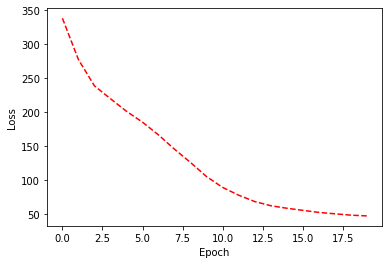

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epoc, training_loss, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Normalized More Epochs and different learning rate 10e-5

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=YOLOTrainDataset(train_images, train_raw_lables),batch_size = 64, shuffle = True)
yolo_net=YOLO()
device = torch.device("cuda:0")
yolo_net=yolo_net.cuda()
learning_rate = 1e-5
optimizer=torch.optim.Adam(yolo_net.parameters(),lr=learning_rate,weight_decay=0.0006)
training_loss = []
epoc = [] 

In [ ]:
train(yolo_net, optimizer, train_loader,65)

  2%|▏         | 1/65 [01:11<1:16:09, 71.41s/it]

Training Loss 713.3180146484375


  3%|▎         | 2/65 [02:23<1:15:11, 71.61s/it]

Training Loss 479.31858520507814


  5%|▍         | 3/65 [03:35<1:14:07, 71.73s/it]

Training Loss 408.45079321289063


  6%|▌         | 4/65 [04:47<1:12:59, 71.80s/it]

Training Loss 363.5859484863281


  8%|▊         | 5/65 [06:00<1:12:01, 72.03s/it]

Training Loss 325.40155517578125


  9%|▉         | 6/65 [07:12<1:10:56, 72.15s/it]

Training Loss 288.0422225341797


 11%|█         | 7/65 [08:25<1:09:52, 72.28s/it]

Training Loss 251.35815771484374


 12%|█▏        | 8/65 [09:37<1:08:48, 72.43s/it]

Training Loss 217.4741717529297


 14%|█▍        | 9/65 [10:50<1:07:34, 72.39s/it]

Training Loss 187.60980383300782


 15%|█▌        | 10/65 [12:02<1:06:20, 72.37s/it]

Training Loss 162.8247940673828


 17%|█▋        | 11/65 [13:15<1:05:12, 72.46s/it]

Training Loss 141.77570458984374


 18%|█▊        | 12/65 [14:27<1:04:01, 72.48s/it]

Training Loss 124.92026007080078


 20%|██        | 13/65 [15:39<1:02:44, 72.39s/it]

Training Loss 110.680744140625


 22%|██▏       | 14/65 [16:52<1:01:29, 72.35s/it]

Training Loss 98.99395281982422


 23%|██▎       | 15/65 [18:04<1:00:19, 72.39s/it]

Training Loss 89.37928436279297


 25%|██▍       | 16/65 [19:17<59:13, 72.52s/it]  

Training Loss 81.1698115234375


 26%|██▌       | 17/65 [20:29<58:00, 72.51s/it]

Training Loss 74.74915301513671


 28%|██▊       | 18/65 [21:41<56:41, 72.37s/it]

Training Loss 68.79569668579101


 29%|██▉       | 19/65 [22:53<55:19, 72.17s/it]

Training Loss 63.71087362670898


 31%|███       | 20/65 [24:04<53:50, 71.79s/it]

Training Loss 59.541997009277345


 32%|███▏      | 21/65 [25:15<52:30, 71.59s/it]

Training Loss 56.07329742431641


 34%|███▍      | 22/65 [26:26<51:09, 71.38s/it]

Training Loss 52.904631744384766


 35%|███▌      | 23/65 [27:37<49:47, 71.13s/it]

Training Loss 50.175073791503905


 37%|███▋      | 24/65 [28:47<48:30, 70.98s/it]

Training Loss 47.51199597167969


 38%|███▊      | 25/65 [29:58<47:19, 70.98s/it]

Training Loss 45.25690542602539


 40%|████      | 26/65 [31:09<46:05, 70.92s/it]

Training Loss 43.3280751953125


 42%|████▏     | 27/65 [32:20<44:53, 70.87s/it]

Training Loss 41.33534222412109


 43%|████▎     | 28/65 [33:31<43:42, 70.88s/it]

Training Loss 39.67661611938477


 45%|████▍     | 29/65 [34:41<42:31, 70.86s/it]

Training Loss 37.98609106445313


 46%|████▌     | 30/65 [35:53<41:22, 70.93s/it]

Training Loss 36.34165270996094


 48%|████▊     | 31/65 [37:03<40:09, 70.88s/it]

Training Loss 35.28680657958984


 49%|████▉     | 32/65 [38:14<38:58, 70.86s/it]

Training Loss 34.02574801635742


 51%|█████     | 33/65 [39:25<37:49, 70.92s/it]

Training Loss 32.58054850769043


 52%|█████▏    | 34/65 [40:36<36:40, 70.98s/it]

Training Loss 31.42366017150879


 54%|█████▍    | 35/65 [41:47<35:24, 70.82s/it]

Training Loss 30.599166076660158


 55%|█████▌    | 36/65 [42:57<34:07, 70.61s/it]

Training Loss 29.382661437988283


 57%|█████▋    | 37/65 [44:07<32:52, 70.45s/it]

Training Loss 28.30277445983887


 58%|█████▊    | 38/65 [45:17<31:41, 70.42s/it]

Training Loss 27.39815800476074


 60%|██████    | 39/65 [46:27<30:26, 70.26s/it]

Training Loss 26.69233267211914


 62%|██████▏   | 40/65 [47:37<29:15, 70.21s/it]

Training Loss 25.868081970214845


 63%|██████▎   | 41/65 [48:47<28:03, 70.14s/it]

Training Loss 25.127142120361327


 65%|██████▍   | 42/65 [49:58<26:54, 70.20s/it]

Training Loss 24.372953063964843


 66%|██████▌   | 43/65 [51:08<25:46, 70.30s/it]

Training Loss 23.471792388916015


 68%|██████▊   | 44/65 [52:19<24:37, 70.34s/it]

Training Loss 22.750223236083983


 69%|██████▉   | 45/65 [53:29<23:28, 70.43s/it]

Training Loss 22.15740673828125


 71%|███████   | 46/65 [54:39<22:17, 70.39s/it]

Training Loss 21.4556436920166


 72%|███████▏  | 47/65 [55:50<21:07, 70.41s/it]

Training Loss 21.150798400878905


 74%|███████▍  | 48/65 [57:00<19:57, 70.44s/it]

Training Loss 20.571542114257813


 75%|███████▌  | 49/65 [58:11<18:46, 70.42s/it]

Training Loss 19.83716704559326


 77%|███████▋  | 50/65 [59:21<17:37, 70.47s/it]

Training Loss 19.29962205505371


 78%|███████▊  | 51/65 [1:00:32<16:26, 70.47s/it]

Training Loss 18.753525787353517


 80%|████████  | 52/65 [1:01:42<15:15, 70.40s/it]

Training Loss 18.36331787109375


 82%|████████▏ | 53/65 [1:02:52<14:04, 70.38s/it]

Training Loss 17.852951469421388


 83%|████████▎ | 54/65 [1:04:03<12:54, 70.41s/it]

Training Loss 17.357889236450195


 85%|████████▍ | 55/65 [1:05:13<11:44, 70.41s/it]

Training Loss 16.865403648376464


 86%|████████▌ | 56/65 [1:06:24<10:34, 70.52s/it]

Training Loss 16.46407192993164


 88%|████████▊ | 57/65 [1:07:35<09:24, 70.54s/it]

Training Loss 16.135990928649903


 89%|████████▉ | 58/65 [1:08:45<08:13, 70.53s/it]

Training Loss 15.8256537399292


 91%|█████████ | 59/65 [1:09:56<07:03, 70.51s/it]

Training Loss 15.518036529541016


 92%|█████████▏| 60/65 [1:11:06<05:52, 70.59s/it]

Training Loss 15.382329162597657


 94%|█████████▍| 61/65 [1:12:17<04:42, 70.64s/it]

Training Loss 14.927634185791016


 95%|█████████▌| 62/65 [1:13:28<03:31, 70.60s/it]

Training Loss 14.606512344360352


 97%|█████████▋| 63/65 [1:14:38<02:21, 70.57s/it]

Training Loss 14.37947859954834


 98%|█████████▊| 64/65 [1:15:49<01:10, 70.52s/it]

Training Loss 14.00428761291504
Training Loss 13.63554020690918


100%|██████████| 65/65 [1:16:59<00:00, 71.08s/it]


[713.3180146484375,
 479.31858520507814,
 408.45079321289063,
 363.5859484863281,
 325.40155517578125,
 288.0422225341797,
 251.35815771484374,
 217.4741717529297,
 187.60980383300782,
 162.8247940673828,
 141.77570458984374,
 124.92026007080078,
 110.680744140625,
 98.99395281982422,
 89.37928436279297,
 81.1698115234375,
 74.74915301513671,
 68.79569668579101,
 63.71087362670898,
 59.541997009277345,
 56.07329742431641,
 52.904631744384766,
 50.175073791503905,
 47.51199597167969,
 45.25690542602539,
 43.3280751953125,
 41.33534222412109,
 39.67661611938477,
 37.98609106445313,
 36.34165270996094,
 35.28680657958984,
 34.02574801635742,
 32.58054850769043,
 31.42366017150879,
 30.599166076660158,
 29.382661437988283,
 28.30277445983887,
 27.39815800476074,
 26.69233267211914,
 25.868081970214845,
 25.127142120361327,
 24.372953063964843,
 23.471792388916015,
 22.750223236083983,
 22.15740673828125,
 21.4556436920166,
 21.150798400878905,
 20.571542114257813,
 19.83716704559326,
 19.2

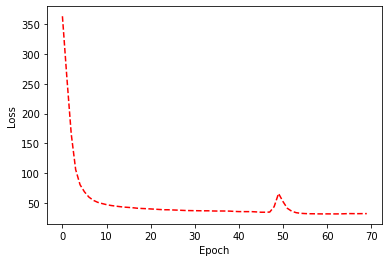

In [ ]:
#70 epochs with Normalization 
plt.plot(epoc_norm, training_loss_norm, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
optimizer=torch.optim.Adam(yolo_net.parameters(),lr=10e-5,weight_decay=0.0006)


In [ ]:
training_loss_norm = []
epoc_norm = []

In [ ]:
def train(net, optimizer, train_loader,epochs):
    overall_step = 0
    
    
    for epoch in tqdm.tqdm(range(epochs)):
      net.train()
      net.to(device)
      train_loss = 0
      for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()
        #images = images.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        outputs = net(images)
        loss = YoloLoss(outputs, labels,lambda_coord.cuda(),lambda_noobj.cuda()).cuda()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
      training_loss_norm.append(train_loss /(i+1))
      print("Training Loss", train_loss / (i+1))
      epoc_norm.append(epoch)
      if epoc == 99:
        path = os.path.join('','yolo_norm_epoc'+str(epoch))
        torch.save({
                  'epoch': epoch,
                  'model_state_dict': yolo_net.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, path)

      #  print(f' \ntrain images {train_loss / len(train_loader)}')

    return training_loss

In [ ]:
train(yolo_net, optimizer, train_loader,100)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  1%|          | 1/100 [01:16<2:06:30, 76.67s/it]

Training Loss 803.6635444335938


  2%|▏         | 2/100 [02:33<2:05:26, 76.80s/it]

Training Loss 531.0135886230469


  3%|▎         | 3/100 [03:50<2:04:20, 76.92s/it]

Training Loss 443.28274609375


  4%|▍         | 4/100 [05:08<2:03:34, 77.23s/it]

Training Loss 391.0296906738281


  5%|▌         | 5/100 [06:26<2:02:32, 77.39s/it]

Training Loss 349.12209545898435


  6%|▌         | 6/100 [07:43<2:01:07, 77.32s/it]

Training Loss 310.2873107910156


  7%|▋         | 7/100 [09:02<2:00:23, 77.67s/it]

Training Loss 272.35643908691407


  8%|▊         | 8/100 [10:20<1:59:09, 77.71s/it]

Training Loss 237.10892138671875


  9%|▉         | 9/100 [11:37<1:57:42, 77.61s/it]

Training Loss 205.14904028320314


 10%|█         | 10/100 [12:54<1:56:18, 77.53s/it]

Training Loss 177.6840104980469


 11%|█         | 11/100 [14:11<1:54:49, 77.41s/it]

Training Loss 154.9521251220703


 12%|█▏        | 12/100 [15:31<1:54:15, 77.90s/it]

Training Loss 136.29695324707032


 13%|█▎        | 13/100 [16:48<1:52:53, 77.85s/it]

Training Loss 120.44294366455078


 14%|█▍        | 14/100 [18:06<1:51:25, 77.74s/it]

Training Loss 107.78541735839843


 15%|█▌        | 15/100 [19:25<1:50:41, 78.14s/it]

Training Loss 97.27577374267578


 16%|█▌        | 16/100 [20:44<1:49:56, 78.52s/it]

Training Loss 88.40883813476563


 17%|█▋        | 17/100 [22:04<1:49:13, 78.96s/it]

Training Loss 80.823447265625


 18%|█▊        | 18/100 [23:22<1:47:17, 78.50s/it]

Training Loss 74.60919812011718


 19%|█▉        | 19/100 [24:38<1:45:16, 77.98s/it]

Training Loss 69.33423602294921


 20%|██        | 20/100 [25:57<1:44:06, 78.08s/it]

Training Loss 64.40697442626953


 21%|██        | 21/100 [27:15<1:42:42, 78.00s/it]

Training Loss 60.12648056030273


 22%|██▏       | 22/100 [28:32<1:41:01, 77.72s/it]

Training Loss 56.61859066772461


 23%|██▎       | 23/100 [29:48<1:39:03, 77.19s/it]

Training Loss 53.176662536621095


 24%|██▍       | 24/100 [31:05<1:37:45, 77.17s/it]

Training Loss 50.67575567626953


 25%|██▌       | 25/100 [32:21<1:36:02, 76.83s/it]

Training Loss 48.26090432739258


 26%|██▌       | 26/100 [33:38<1:35:05, 77.10s/it]

Training Loss 46.05932604980469


 27%|██▋       | 27/100 [34:55<1:33:27, 76.81s/it]

Training Loss 43.51423721313476


 28%|██▊       | 28/100 [36:11<1:32:00, 76.68s/it]

Training Loss 41.998770751953124


 29%|██▉       | 29/100 [37:28<1:30:48, 76.73s/it]

Training Loss 40.66909768676758


 30%|███       | 30/100 [38:42<1:28:41, 76.02s/it]

Training Loss 38.53997640991211


 31%|███       | 31/100 [39:57<1:27:08, 75.78s/it]

Training Loss 37.170226959228515


 32%|███▏      | 32/100 [41:16<1:26:41, 76.49s/it]

Training Loss 35.497435592651364


 33%|███▎      | 33/100 [42:32<1:25:31, 76.59s/it]

Training Loss 34.31355477905274


 34%|███▍      | 34/100 [43:49<1:24:22, 76.70s/it]

Training Loss 32.99485359191895


 35%|███▌      | 35/100 [45:07<1:23:19, 76.91s/it]

Training Loss 31.851062942504882


 36%|███▌      | 36/100 [46:25<1:22:20, 77.19s/it]

Training Loss 30.900459915161132


 37%|███▋      | 37/100 [47:42<1:21:00, 77.16s/it]

Training Loss 29.776473037719725


 38%|███▊      | 38/100 [48:58<1:19:29, 76.93s/it]

Training Loss 28.977017684936524


 39%|███▉      | 39/100 [50:15<1:18:09, 76.87s/it]

Training Loss 27.91204621887207


 40%|████      | 40/100 [51:32<1:17:05, 77.09s/it]

Training Loss 27.03333282470703


 41%|████      | 41/100 [52:51<1:16:09, 77.45s/it]

Training Loss 26.066709930419922


 42%|████▏     | 42/100 [54:06<1:14:06, 76.66s/it]

Training Loss 25.40176936340332


 43%|████▎     | 43/100 [55:20<1:12:10, 75.97s/it]

Training Loss 24.672931335449217


 44%|████▍     | 44/100 [56:35<1:10:33, 75.60s/it]

Training Loss 24.014254211425783


 45%|████▌     | 45/100 [57:49<1:08:59, 75.26s/it]

Training Loss 23.169955490112304


 46%|████▌     | 46/100 [59:04<1:07:46, 75.30s/it]

Training Loss 22.6895078125


 47%|████▋     | 47/100 [1:00:19<1:06:13, 74.96s/it]

Training Loss 21.93736083984375


 48%|████▊     | 48/100 [1:01:32<1:04:39, 74.61s/it]

Training Loss 21.186501541137694


 49%|████▉     | 49/100 [1:02:46<1:03:03, 74.18s/it]

Training Loss 20.83535920715332


 50%|█████     | 50/100 [1:03:59<1:01:39, 73.99s/it]

Training Loss 20.121086822509767


 51%|█████     | 51/100 [1:05:10<59:45, 73.17s/it]  

Training Loss 19.71072621154785


 52%|█████▏    | 52/100 [1:06:22<58:08, 72.69s/it]

Training Loss 19.028495803833007


 53%|█████▎    | 53/100 [1:07:36<57:12, 73.03s/it]

Training Loss 18.605738319396973


 54%|█████▍    | 54/100 [1:08:49<56:05, 73.15s/it]

Training Loss 18.36045156097412


 55%|█████▌    | 55/100 [1:10:00<54:19, 72.42s/it]

Training Loss 17.740668922424316


 56%|█████▌    | 56/100 [1:11:12<52:58, 72.23s/it]

Training Loss 17.272410301208495


 57%|█████▋    | 57/100 [1:12:25<51:56, 72.49s/it]

Training Loss 16.768690986633302


 58%|█████▊    | 58/100 [1:13:38<50:56, 72.77s/it]

Training Loss 16.3455810546875


 59%|█████▉    | 59/100 [1:14:51<49:47, 72.87s/it]

Training Loss 16.042965003967286


 60%|██████    | 60/100 [1:16:02<48:07, 72.18s/it]

Training Loss 15.872430625915527


 61%|██████    | 61/100 [1:17:14<46:53, 72.13s/it]

Training Loss 15.437511383056641


 62%|██████▏   | 62/100 [1:18:26<45:35, 71.99s/it]

Training Loss 15.046658042907715


 63%|██████▎   | 63/100 [1:19:37<44:21, 71.92s/it]

Training Loss 14.72841893005371


 64%|██████▍   | 64/100 [1:20:50<43:16, 72.11s/it]

Training Loss 14.519873718261719


 65%|██████▌   | 65/100 [1:22:02<42:02, 72.06s/it]

Training Loss 14.376410675048827


 66%|██████▌   | 66/100 [1:23:14<40:49, 72.03s/it]

Training Loss 13.982441062927245


 67%|██████▋   | 67/100 [1:24:25<39:29, 71.80s/it]

Training Loss 13.633227546691895


 68%|██████▊   | 68/100 [1:25:38<38:26, 72.07s/it]

Training Loss 13.499440986633301


 69%|██████▉   | 69/100 [1:26:50<37:15, 72.12s/it]

Training Loss 13.185791793823242


 70%|███████   | 70/100 [1:28:03<36:11, 72.39s/it]

Training Loss 13.163169441223145


 71%|███████   | 71/100 [1:29:17<35:12, 72.86s/it]

Training Loss 12.777407424926757


 72%|███████▏  | 72/100 [1:30:30<34:03, 72.97s/it]

Training Loss 12.489987342834473


 73%|███████▎  | 73/100 [1:31:45<33:07, 73.61s/it]

Training Loss 12.23748069000244


 74%|███████▍  | 74/100 [1:33:01<32:09, 74.20s/it]

Training Loss 11.870229377746583


 75%|███████▌  | 75/100 [1:34:17<31:07, 74.72s/it]

Training Loss 11.954130821228027


 76%|███████▌  | 76/100 [1:35:32<29:56, 74.87s/it]

Training Loss 12.029789260864257


 77%|███████▋  | 77/100 [1:36:46<28:38, 74.73s/it]

Training Loss 11.663648452758789


 78%|███████▊  | 78/100 [1:38:02<27:29, 74.96s/it]

Training Loss 11.389219970703126


 79%|███████▉  | 79/100 [1:39:18<26:22, 75.35s/it]

Training Loss 11.380551551818847


 80%|████████  | 80/100 [1:40:35<25:15, 75.79s/it]

Training Loss 11.200552940368652


 81%|████████  | 81/100 [1:41:50<23:56, 75.61s/it]

Training Loss 10.971595947265625


 82%|████████▏ | 82/100 [1:43:05<22:38, 75.46s/it]

Training Loss 11.038423244476318


 83%|████████▎ | 83/100 [1:44:22<21:26, 75.69s/it]

Training Loss 10.598501838684083


 84%|████████▍ | 84/100 [1:45:38<20:14, 75.89s/it]

Training Loss 10.501056442260742


 85%|████████▌ | 85/100 [1:46:54<18:58, 75.92s/it]

Training Loss 10.31203012084961


 86%|████████▌ | 86/100 [1:48:09<17:41, 75.80s/it]

Training Loss 10.18276343536377


 87%|████████▋ | 87/100 [1:49:26<16:30, 76.16s/it]

Training Loss 10.102055332183838


 88%|████████▊ | 88/100 [1:50:43<15:14, 76.18s/it]

Training Loss 9.959460670471191


 89%|████████▉ | 89/100 [1:52:00<14:00, 76.38s/it]

Training Loss 9.905455661773681


 90%|█████████ | 90/100 [1:53:16<12:42, 76.27s/it]

Training Loss 9.79804335784912


 91%|█████████ | 91/100 [1:54:31<11:25, 76.16s/it]

Training Loss 9.769772903442384


 92%|█████████▏| 92/100 [1:55:48<10:10, 76.25s/it]

Training Loss 9.69270902633667


 93%|█████████▎| 93/100 [1:57:03<08:51, 75.92s/it]

Training Loss 9.45119271850586


 94%|█████████▍| 94/100 [1:58:20<07:37, 76.19s/it]

Training Loss 9.328331146240235


 95%|█████████▌| 95/100 [1:59:37<06:23, 76.62s/it]

Training Loss 9.397843669891357


 96%|█████████▌| 96/100 [2:00:55<05:07, 76.84s/it]

Training Loss 9.200913276672363


 97%|█████████▋| 97/100 [2:02:13<03:51, 77.12s/it]

Training Loss 9.091429813385009


 98%|█████████▊| 98/100 [2:03:30<02:34, 77.07s/it]

Training Loss 9.139968799591065


 99%|█████████▉| 99/100 [2:04:46<01:16, 76.98s/it]

Training Loss 8.91041773223877


100%|██████████| 100/100 [2:06:03<00:00, 75.63s/it]

Training Loss 8.791845726013184


[]

In [ ]:
train(yolo_net, optimizer, train_loader,100)

# Image Visualization 

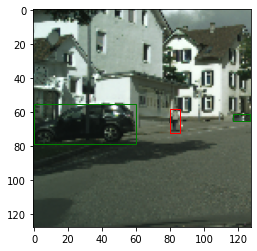

In [ ]:
train_dataset = YOLODataset(test_images, test_raw_labels)
image,label = train_dataset.__getitem__(87)
label1 = create_y_label(image,label)
image = image.type(torch.IntTensor).numpy()
image = np.transpose(image,(1,2,0))
fig,ax = plt.subplots(1)
ax.imshow(image)
for i in range(8):
  label1[i] = label1[i].T

for i in range(8):
  for j in range(8):
    if label1[0][i][j]>0.5:
      if label1[5][i][j]>0.5:
        width = label1[3][i][j]*128
        height = label1[4][i][j]*128
        xcoord = label1[1][i][j]*16 + j*16 -width/2
        ycoord = label1[2][i][j]*16 + i*16 - height/2
        rect1 = patches.Rectangle((xcoord,ycoord),width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
      if label1[6][i][j]>0.5:
        width = label1[3][i][j]*128
        height = label1[4][i][j]*128
        xcoord = label1[1][i][j]*16 + j*16 - width/2
        ycoord = label1[2][i][j]*16 + i*16 - height/2
        rect2 = patches.Rectangle((xcoord,ycoord),width,height,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect2)
      if label1[7][i][j]>0.5:4/4wEAh8zn9DD9LR_EZYzRIevfr6CMB0blg46Xf5zVnP2jbfVyVYvaeGg
        width = label1[3][i][j]*128
        height = label1[4][i][j]*128
        xcoord = label1[1][i][j]*16 + j*16 - width/2
        ycoord = label1[2][i][j]*16 + i*16 - height/2
        rect3 = patches.Rectangle((xcoord,ycoord),width,height,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect3)
        
plt.show()

# Non-Max Suppression 


In [ ]:
path = "/content/drive/My Drive/yolo_work_epocfinal"
checkpoint = torch.load(path)
yolo_net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=YOLOTrainDataset(test_images, test_raw_labels),batch_size = 64, shuffle = True)

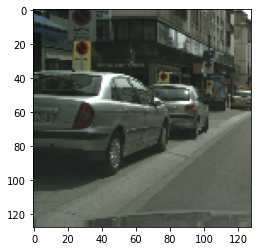

In [ ]:
for i,(image,llabel) in enumerate(test_loader):
  plt.imshow(np.transpose(image[0].numpy(), (1, 2, 0)))


In [ ]:
for data, target in test_loader:
    data, target = data.cuda(), target.cuda()

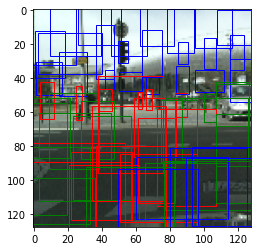

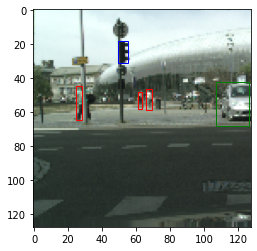

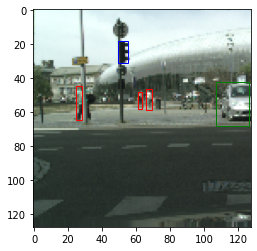

In [ ]:
output = yolo_net(data)
image = data.cpu().numpy()
image = image[14]
image = np.transpose(image,(1,2,0))
fig1,ax1 = plt.subplots(1) 
fig2,ax2 = plt.subplots(1)
fig,ax = plt.subplots(1)  
label = output[14].cpu().detach().numpy()
for i in range(8):
  label[i] = label[i].T

all_images = ax1.imshow(image)
objectness = (target[:,0]==1.0).type(torch.Tensor).cuda()
for i in range(8):
  for j in range(8):
    if label[0][i][j]>0.0:
      bool_label5 = (label[5][i][j]>label[6][i][j]) and (label[5][i][j]>label[7][i][j])
      bool_label6 = (label[6][i][j]>label[5][i][j]) and (label[6][i][j]>label[7][i][j])
      bool_label7 = (label[7][i][j]>label[6][i][j]) and (label[7][i][j]>label[5][i][j])
      if label[5][i][j]>0.0 and bool_label5:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 -width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect1 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax1.add_patch(rect1)
      if label[6][i][j]>0.0 and bool_label6:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect2 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='b',facecolor='none')
        ax1.add_patch(rect2)
      if label[7][i][j]>0.0 and bool_label7:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect3 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='g',facecolor='none')
        ax1.add_patch(rect3)
     


#Suppression 

objectness = (label[0]>0.6).astype(int)
for i in range(1,8):
  if label[0].any() > 0.6:
    label[i] = (label[0]>0.6).astype(int) * (label[i]) 


for i in range(8):
  for j in range(8):
    max_val = max(label[5][i][j],label[6][i][j],label[7][i][j])
    if label[5][i][j] != max_val:
      label[5][i][j] = 0
    if label[6][i][j] != max_val:
      label[6][i][j] = 0
    if label[7][i][j] != max_val:
      label[7][i][j] = 0


ax2.imshow(image)
for i in range(8):
  for j in range(8):
    if label[0][i][j]>0.0:
      if label[5][i][j]>0.0:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 -width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect1 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax2.add_patch(rect1)
      if label[6][i][j]>0.0:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect2 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='b',facecolor='none')
        ax2.add_patch(rect2)
      if label[7][i][j]>0.0:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect3 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='g',facecolor='none')
        ax2.add_patch(rect3)


for c in range(5,8):
  for i in range(8):
    for j in range(8):
      
      
      abox = torch.zeros(4)
      re_w=label[3][i][j]*128
      re_h=label[4][i][j]*128
      re_x=label[1][i][j]*16
      re_y=label[2][i][j]*16    

      abox[0] = j *16 + re_x -re_w/2
      abox[1] = j *16 + re_y +re_h/2
      abox[2] = i *16 + re_x  - re_w/2
      abox[3] = i*16 + re_y  + re_h/2
      
      for p in range(8):
        for q in range(8):
          # if(label[c][p][q]==0): 
          #   continue
          if(p!=i and q!=j):
      
            bbox = torch.zeros(4)
            re_w=label[3][p][q]*128
            re_h=label[4][p][q]*128
            re_x=label[1][p][q]*16
            re_y=label[2][p][q]*16    
            
            bbox[0] = q *16 + re_x -re_w/2
            bbox[1] = q *16 + re_y +re_h/2
            bbox[2] = p *16 + re_x  - re_w/2
            bbox[3] = p *16 + re_y  + re_h/2

           
            iou = IOU(abox,bbox)
           # print("IOU",iou)

            if iou > 0.5:
              if label[c][i][j]>label[c][p][q]:
                label[0][p][q] = 0
              elif label[c][i][j]<label[c][p][q]:
                label[0][i][j] = 0
              
              
ax.imshow(image)


for i in range(8):
  for j in range(8):
    if label[0][i][j]>0.6:
      if label[5][i][j]>0.5:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 -width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect1 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
      if label[6][i][j]>0.5:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect2 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect2)
      if label[7][i][j]>0.5:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect3 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect3)

        
plt.show()

In [ ]:
def train(net, optimizer, train_loader,epochs):
    overall_step = 0
    
    path = '/content/yolo_norm_epocfinal' # set this to where the checkpoint is saved 
    resume = True # set this True if you want to resume training from a checkpoint
    if resume == True:
      checkpoint = torch.load(path)
      yolo_net.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      epochs = checkpoint['epoch']

    for epoch in tqdm.tqdm(range(35)):
      net.train()
      net.to(device)
      train_loss = 0
      for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()
        #images = images.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        outputs = net(images)
        loss = YoloLoss(outputs, labels,lambda_coord.cuda(),lambda_noobj.cuda()).cuda()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
      #training_loss_norm.append(train_loss /(i+1))
      print("Training Loss", train_loss / (i+1))
      #epoc_norm.append(epoch)
      # if epoch == 34:
      #   path = os.path.join('','yolo_retrained_epoc'+str(epoch))
      #   torch.save({
      #             'epoch': epoch,
      #             'model_state_dict': yolo_net.state_dict(),
      #             'optimizer_state_dict': optimizer.state_dict()
      #             }, path)

      #  print(f' \ntrain images {train_loss / len(train_loader)}')

    return training_loss

In [ ]:
path = os.path.join('','yolo_work_epocfinal')
torch.save({
          'epoch': 34,
          'model_state_dict': yolo_net.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          }, path)

# Mean Average Precision


In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=YOLOTrainDataset(test_images, test_raw_labels),batch_size = 64, shuffle = True)

In [ ]:
def yolo_evaluation(label,target):
  true_0=0
  true_1=0
  true_2=0
  label_class=torch.zeros(3)
  target_class=torch.zeros(3)
  for i in range(8):
    for j in range(8):
      if (target[0][i][j]==1):
        #First Bounding Box
        bounding_box1 = torch.zeros(4)
        re_w=label[3][i][j]*128
        re_h=label[4][i][j]*128
        re_x=label[1][i][j]*16
        re_y=label[2][i][j]*16    
        bounding_box1[0] = j *16 + re_x -re_w/2
        bounding_box1[1] = j *16 + re_y +re_h/2
        bounding_box1[2] = i *16 + re_x  - re_w/2
        bounding_box1[3] = i*16 + re_y  + re_h/2
        #Second Bounding Box
        bounding_box2 = torch.zeros(4)
        re_w=target[3][i][j]*128
        re_h=target[4][i][j]*128
        re_x=target[1][i][j]*16
        re_y=target[2][i][j]*16    
        bounding_box2[0] = j *16 + re_x -re_w/2
        bounding_box2[1] = j *16 + re_y +re_h/2
        bounding_box2[2] = i *16 + re_x  - re_w/2
        bounding_box2[3] = i*16 + re_y  + re_h/2
        #5,6,7 index are class labels - pedestrians, cars and traffic lights
        label_class[0]=label[5][i][j]
        label_class[1]=label[6][i][j]
        label_class[2]=label[7][i][j]
        #We do this because we would need to get which class has the highest probability. The index value gives the index whether 0,1 or 2 is the highest value
        dont_care1,label_compare=torch.max(label_class,0)

        target_class[0]=target[5][i][j]
        target_class[1]=target[6][i][j]
        target_class[2]=target[7][i][j]
        dont_care2,target_compare=torch.max(target_class,0)

        #True Value Count 
        if (target_compare==0):
          true_0+=1
        elif (target_compare==1):
          true_1+=1
        elif (target_compare==2):
          true_2+=1   

        IOU_bounding_box = IOU(bounding_box1 ,bounding_box2)

        #Checks if the classes are the same or not.
        #If the classes are the same, they are checked if the IOU between them is greater than 0.5. If so, 1 is appended to the matches list.
        #If the classes are not the same, 0 is added to the list. 
        #Comparison if the label prediction is 0
        if (label_compare==0 and target_compare!=0):
          match_class[0].append(0)
          score_class[0].append(IOU_bounding_box)
        elif (label_compare==0 and target_compare==0 and IOU_bounding_box>0.5):
          match_class[0].append(1)
          score_class[0].append(IOU_bounding_box)
        elif (label_compare==0 and target_compare==0 and IOU_bounding_box<0.5):   
          match_class[0].append(0)
          score_class[0].append(IOU_bounding_box)

        #Comparison if the label prediction is 1
        if (label_compare==1 and target_compare!=1):
          match_class[1].append(0)
          score_class[1].append(IOU_bounding_box)  
        elif (label_compare==1 and target_compare==1 and IOU_bounding_box>0.5):
          match_class[1].append(1)
          score_class[1].append(IOU_bounding_box)
        elif (label_compare==1 and target_compare==1 and IOU_bounding_box<0.5):   
          match_class[1].append(0)
          score_class[1].append(IOU_bounding_box)

          #Comparison if the label prediction is 2
        if (label_compare==2 and target_compare!=2):
          match_class[2].append(0)
          score_class[2].append(IOU_bounding_box) 
        elif (label_compare==2 and target_compare==2 and IOU_bounding_box>0.5):
          match_class[2].append(1)
          score_class[2].append(IOU_bounding_box)
        elif (label_compare==2 and target_compare==2 and IOU_bounding_box<0.5):   
          match_class[2].append(0)
          score_class[2].append(IOU_bounding_box)
        
          
        
  return match_class,score_class,true_0,true_1,true_2          


In [ ]:
def nms(label):
  # for i in range(1,8):
  #   if label[0].all() > 0.6:
  #     label[i] = (label[0]>0.6).astype(int) * (label[i])

  for k in range(5,8):
    for i in range(8):
      for j in range(8):
        if label[0][i][j]>0.6:
          bounding_box1 = torch.zeros(4)
          re_w=label[3][i][j]*128
          re_h=label[4][i][j]*128
          re_x=label[1][i][j]*16
          re_y=label[2][i][j]*16    
          bounding_box1[0] = j *16 + re_x -re_w/2
          bounding_box1[1] = j *16 + re_y +re_h/2
          bounding_box1[2] = i *16 + re_x  - re_w/2
          bounding_box1[3] = i*16 + re_y  + re_h/2

          for p in range(8):
            for q in range(8):
              if label[0][p][q]>0.6:
                if(p!=i and q!=j):
                  bounding_box2 = torch.zeros(4)
                  re_w=label[3][p][q]*128
                  re_h=label[4][p][q]*128
                  re_x=label[1][p][q]*16
                  re_y=label[2][p][q]*16    
                  bounding_box2[0] = q *16 + re_x -re_w/2
                  bounding_box2[1] = q *16 + re_y +re_h/2
                  bounding_box2[2] = p *16 + re_x  - re_w/2
                  bounding_box2[3] = p*16 + re_y  + re_h/2
                  iou = IOU(bounding_box1,bounding_box2)
                  if iou > 0.5:
                    if label[k][i][j]>label[k][p][q]:
                      label[0][p][q] = 0
                    elif label[k][i][j]<label[k][p][q]:
                      label[0][i][j] = 0
  return label

In [ ]:
def average_precision(match, score, true):
  tot_pos=0
  TP=0
  maximum_score= np.max(score)
  ln= np.linspace(0.6,maximum_score,num=100)
  precision_mat= np.zeros((101))
  recall_mat= np.zeros((101))
  for i in range(len(ln)):
    tot_pos=0
    TP=0
    th=ln[i]
    for j in range(len(match)):
      if (match[j]==1):
        tot_pos+=1
        if (score[j]>th):
          TP+=1
    precision=1
    if tot_pos>0:
      precision=TP/tot_pos
      recall=1
    if true>0:
      recall=TP/true
    precision_mat[i]=precision
    recall_mat[i]=recall
  recall_mat[100]=0
  sorted_ind=np.argsort(recall_mat)
  sorted_recall=recall_mat[sorted_ind]
  sorted_precision=precision_mat
  area=auc(sorted_recall,sorted_precision)
  return area,sorted_precision,sorted_recall

# Precision-Recall Curve

In [ ]:
sum1=0
sum2=0
sum3=0
match_class = {0: [], 1: [],2: []}
score_class = {0: [], 1: [],2: []}
true_0=0
true_1=0
true_2=0
with torch.no_grad():
  yolo_net.eval()
  for idx,(data,target) in enumerate(test_loader):
    data=data.float()
    data=data.to(device)
    target=target.to(device)
    optimizer.zero_grad()
    output=yolo_net(data)
     # output = output.squeeze(0)
    # target = target.squeeze(0)
    # data = input.squeeze(0)
    #output = nms(output)
    for i in range(len(output)):
      output[i]=nms(output[i])
      match_class,score_class,true_0,true_1,true_2=yolo_evaluation(output[i],target[i])
      sum1+=true_0
      sum2+=true_1
      sum3+=true_2
cnt=0
AP=0
if len(match_class[0])>0:
  AP1,_,_=average_precision(match_class[0],score_class[0],sum1)
  cnt+=1
if len(match_class[1])>0:
  AP2,_,_=average_precision(match_class[1],score_class[1],sum2)
  cnt+=1
if len(match_class[2])>0:
  AP3,_,_=average_precision(match_class[2],score_class[2],sum3)
  cnt+=1
if cnt>0:
  mAp = (AP1+AP2+AP3)/cnt

In [ ]:
area_1,precision_1,recall_1=average_precision(match_class[0],score_class[0],sum1)
area_2,precision_2,recall_2=average_precision(match_class[1],score_class[1],sum2)
area_3,precision_3,recall_3=average_precision(match_class[2],score_class[2],sum3)

In [ ]:
from sklearn.metrics import auc

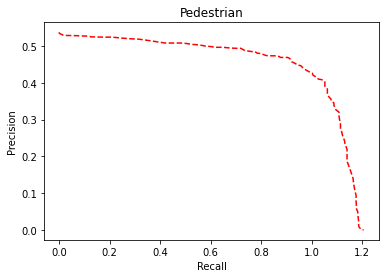

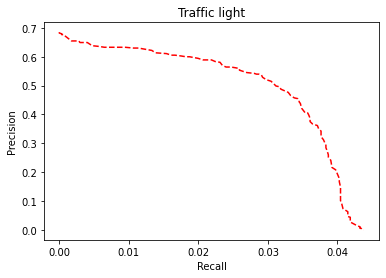

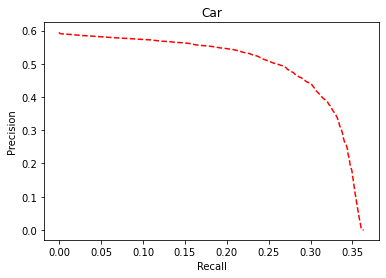

In [ ]:
plt.plot(recall_1,precision_1,'r--')
plt.title('Pedestrian')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

plt.plot(recall_2,precision_2,'r--')
plt.title('Traffic light')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

plt.plot(recall_3,precision_3,'r--')
plt.title('Car')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

# Training Loop

In [ ]:
import tqdm
yolo_net=YOLO()
device = torch.device("cuda")
yolo_net=yolo_net.to(device)
optimizer=torch.optim.Adam(yolo_net.parameters(),lr=1e-5,weight_decay=0.0001)
path = '/content/yolo_epoch' 
if resume == True:
  checkpoint = torch.load(path)
  yolo_net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epochs = checkpoint['epoch']
mean_avg=[]
epochnum=[]
ap0=[]
ap1=[]
ap2=[]

In [ ]:
def train(net, optimizer, train_loader,test_loader,epo):
  for epochs in tqdm.tqdm(range(epo)):
    ## fill in your training code
    yolo_net.train()
    correct=0
    overall_loss = 0
    total = 0
    for idx,(data,target) in enumerate(train_loader):
      data=data.float()
      data,target = data.to(device),target.to(device)
      optimizer.zero_grad()
      output = yolo_net(data)
      output=output.cuda()
      target=target.cuda()
      loss = YoloLoss(output, target, lambda_coord.cuda(), lambda_noobj.cuda()).cuda()
      overall_loss+=loss.item()
      loss.backward()
      optimizer.step()
    # print(epochs,"Train loss",loss)
    print("Train loss",overall_loss/(idx+1))
    sum1=0
    sum2=0
    sum3=0
    match_class = {0: [], 1: [],2: []}
    score_class = {0: [], 1: [],2: []}
    true_0=0
    true_1=0
    true_2=0

    with torch.no_grad():
      yolo_net.eval()
      for idx,(data,target) in enumerate(test_loader):
        data=data.float()
        data=data.to(device)
        target=target.to(device)
        optimizer.zero_grad()
        output=yolo_net(data)
        for i in range(len(output)):
          output[i]=nms(output[i])
          match_class,score_class,true_0,true_1,true_2=yolo_evaluation(output[i],target[i])
          sum1+=true_0
          sum2+=true_1
          sum3+=true_2
      cnt=0
      AP=0
      if len(match_class[0])>0:
        AP1,_,_=average_precision(match_class[0],score_class[0],sum1)
        cnt+=1
      if len(match_class[1])>0:
        AP2,_,_=average_precision(match_class[1],score_class[1],sum2)
        cnt+=1
      if len(match_class[2])>0:
        AP3,_,_=average_precision(match_class[2],score_class[2],sum3)
        cnt+=1
      if cnt>0:
        mAp = (AP1+AP2+AP3)/cnt
        print("MAP",mAp)
        epochnum.append(epochs)
        mean_avg.append(mAp)
        ap0.append(AP1)
        ap1.append(AP2)
        ap2.append(AP3)



train(yolo_net, optimizer, train_loader,test_loader,50)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


Train loss 1059.5960048828124
MAP 0.024120919318185014


  2%|▏         | 1/50 [02:55<2:23:13, 175.38s/it]

Train loss 719.8301884765625
MAP 0.028999166594361307


  4%|▍         | 2/50 [05:21<2:13:23, 166.74s/it]

Train loss 611.8638188476563
MAP 0.03328973562008664


  6%|▌         | 3/50 [07:44<2:04:55, 159.47s/it]

Train loss 547.6751157226563
MAP 0.03542716076680278


  8%|▊         | 4/50 [10:06<1:58:15, 154.24s/it]

Train loss 498.86716552734373
MAP 0.03998128350577821


 10%|█         | 5/50 [12:26<1:52:34, 150.10s/it]

Train loss 454.3665244140625
MAP 0.042944012142813466


 12%|█▏        | 6/50 [14:44<1:47:19, 146.34s/it]

Train loss 410.4510048828125
MAP 0.04586172207635877


 14%|█▍        | 7/50 [16:58<1:42:09, 142.56s/it]

Train loss 366.92586474609374
MAP 0.053603671055172386


 16%|█▌        | 8/50 [19:11<1:37:47, 139.71s/it]

Train loss 325.8295625
MAP 0.060464784144600915


 18%|█▊        | 9/50 [21:23<1:33:56, 137.48s/it]

Train loss 289.1061423339844
MAP 0.07159872590254025


 20%|██        | 10/50 [23:34<1:30:25, 135.64s/it]

Train loss 256.8779135742187
MAP 0.07960756536917167


 22%|██▏       | 11/50 [25:45<1:27:15, 134.24s/it]

Train loss 228.9700478515625
MAP 0.08785814818098904


 24%|██▍       | 12/50 [27:55<1:24:03, 132.71s/it]

Train loss 205.6368856201172
MAP 0.09553985123188553


 26%|██▌       | 13/50 [30:03<1:21:01, 131.39s/it]

Train loss 185.34281701660157
MAP 0.10550516306062803


 28%|██▊       | 14/50 [32:16<1:19:12, 132.00s/it]

Train loss 167.4190283203125
MAP 0.11043384704816694


 30%|███       | 15/50 [34:21<1:15:44, 129.85s/it]

Train loss 151.73974755859376
MAP 0.12000765436966054


 32%|███▏      | 16/50 [36:29<1:13:17, 129.32s/it]

Train loss 137.67744641113282
MAP 0.12837060069152265


 34%|███▍      | 17/50 [38:34<1:10:19, 127.86s/it]

Train loss 125.04233428955078
MAP 0.13136025516216088


 36%|███▌      | 18/50 [40:41<1:08:07, 127.75s/it]

Train loss 114.2491763305664
MAP 0.14282845965656407


 38%|███▊      | 19/50 [42:46<1:05:35, 126.94s/it]

Train loss 104.57581665039062
MAP 0.1464537877930157


 40%|████      | 20/50 [44:52<1:03:21, 126.71s/it]

Train loss 95.40843334960938
MAP 0.15039620535413759


 42%|████▏     | 21/50 [46:59<1:01:17, 126.82s/it]

Train loss 87.42955377197265
MAP 0.15722253065960307


 44%|████▍     | 22/50 [49:07<59:17, 127.05s/it]  

Train loss 79.79876635742187
MAP 0.15949698086769543


 46%|████▌     | 23/50 [51:14<57:05, 126.88s/it]

Train loss 72.66854614257812
MAP 0.16487995062255278


 48%|████▊     | 24/50 [53:17<54:32, 125.87s/it]

Train loss 66.45230905151367
MAP 0.16835436214495525


 50%|█████     | 25/50 [55:23<52:23, 125.75s/it]

Train loss 60.76036776733398
MAP 0.17216210573727156


 52%|█████▏    | 26/50 [57:28<50:17, 125.75s/it]

Train loss 55.10762707519531
MAP 0.1814421541886453


 54%|█████▍    | 27/50 [59:33<48:07, 125.54s/it]

Train loss 50.69439489746094
MAP 0.17531741713293794


 56%|█████▌    | 28/50 [1:01:35<45:36, 124.37s/it]

Train loss 46.49006079101562
MAP 0.18258525237223075


 58%|█████▊    | 29/50 [1:03:40<43:36, 124.62s/it]

Train loss 42.68229055786133
MAP 0.18063399605360633


 60%|██████    | 30/50 [1:05:45<41:34, 124.71s/it]

Train loss 39.33504678344727
MAP 0.186669714425275


 62%|██████▏   | 31/50 [1:07:48<39:21, 124.31s/it]

Train loss 35.74384651184082
MAP 0.18449242134488705


 64%|██████▍   | 32/50 [1:09:55<37:27, 124.86s/it]

Train loss 33.053560180664064
MAP 0.18788850896455198


 66%|██████▌   | 33/50 [1:12:01<35:32, 125.46s/it]

Train loss 30.481207748413087
MAP 0.19503578064210778


 68%|██████▊   | 34/50 [1:14:08<33:30, 125.68s/it]

Train loss 27.81791572570801
MAP 0.19189240247393827


 70%|███████   | 35/50 [1:16:15<31:33, 126.24s/it]

Train loss 25.966870208740236
MAP 0.19453958859519807


 72%|███████▏  | 36/50 [1:18:20<29:21, 125.80s/it]

Train loss 24.104065689086916
MAP 0.19225727028508435


 74%|███████▍  | 37/50 [1:20:27<27:21, 126.27s/it]

Train loss 22.36632307434082
MAP 0.19486579876504725


 76%|███████▌  | 38/50 [1:22:35<25:21, 126.81s/it]

Train loss 20.839858207702637
MAP 0.19427620207430016


 78%|███████▊  | 39/50 [1:24:43<23:16, 126.92s/it]

Train loss 19.39879999542236
MAP 0.19211321122839253


 80%|████████  | 40/50 [1:26:50<21:09, 126.92s/it]

Train loss 18.12991014099121
MAP 0.19518834620123862


 82%|████████▏ | 41/50 [1:28:56<19:01, 126.84s/it]

Train loss 17.04994652557373
MAP 0.1890980095058973


 84%|████████▍ | 42/50 [1:31:09<17:08, 128.54s/it]

Train loss 16.26856990814209
MAP 0.18910402153719252


 86%|████████▌ | 43/50 [1:33:20<15:05, 129.42s/it]

Train loss 15.16275392150879
MAP 0.19212190504202212


 88%|████████▊ | 44/50 [1:35:32<13:01, 130.27s/it]

Train loss 14.169918754577637
MAP 0.19154590272218605


 90%|█████████ | 45/50 [1:37:46<10:56, 131.36s/it]

Train loss 13.354261657714844
MAP 0.19474825702355103


 92%|█████████▏| 46/50 [1:39:58<08:45, 131.47s/it]

Train loss 12.676687477111816
MAP 0.19712602891581757


 94%|█████████▍| 47/50 [1:42:12<06:36, 132.19s/it]

Train loss 11.991301048278808
MAP 0.1951221256208124


 96%|█████████▌| 48/50 [1:44:27<04:26, 133.11s/it]

Train loss 11.73392707824707
MAP 0.19546910017795002


 98%|█████████▊| 49/50 [1:46:39<02:12, 132.70s/it]

Train loss 10.980984191894532
MAP 0.1931960318439466


100%|██████████| 50/50 [1:48:50<00:00, 130.61s/it]


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=YOLOTrainDataset(train_images, train_raw_lables),batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=YOLOTrainDataset(test_images, test_raw_labels),batch_size = 64, shuffle = True)
yolo_net=YOLO()
device = torch.device("cuda:0")
yolo_net=yolo_net.cuda()
learning_rate = 1e-5
optimizer=torch.optim.Adam(yolo_net.parameters(),lr=learning_rate,weight_decay=0.0006)
training_loss = []
epoc = [] 
map = []
epoch = []

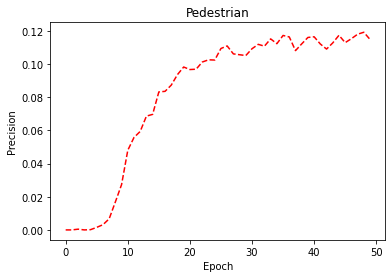

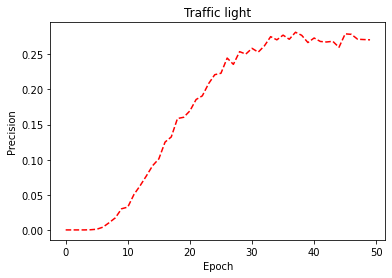

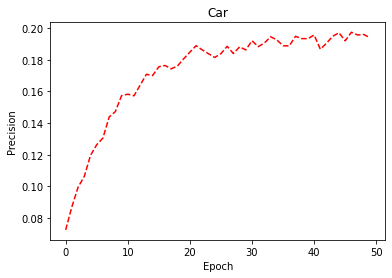

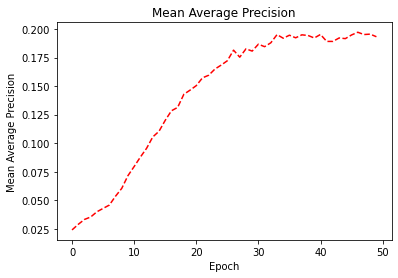

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_count,ap1,'r--')
plt.title('Pedestrian')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.show()

plt.plot(epoch_count,ap2,'r--')
plt.title('Traffic light')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.show()

plt.plot(epoch_count,ap3,'r--')
plt.title('Car')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.show()

plt.plot(epochnum,mean_avg,'r--')
plt.title('Mean Average Precision')
plt.ylabel('Mean Average Precision')
plt.xlabel('Epoch')
plt.show()

# mAP Graph

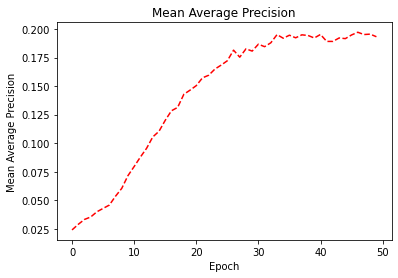

In [ ]:

plt.plot(epochnum,mean_avg,'r--')
plt.title('Mean Average Precision')
plt.ylabel('Mean Average Precision')
plt.xlabel('Epoch')
plt.show()